# 10x scRNA-seq gene expression data (part 2b)

Using the cached results from part 2a, we can continue to explore our examples looking at the expression of canonical neurotransmitter transporter genes and gene Tac2 over the whole brain.

In [1]:
import os
import pandas as pd
import numpy as np
import anndata
import time
import json
import matplotlib.pyplot as plt

In [2]:
download_base = '/allen/programs/celltypes/workgroups/rnaseqanalysis/lydian/ABC_handoff'
release_directory = os.path.join( download_base, 'releases', '20230630')
file = os.path.join( release_directory, 'manifest.json')
with open(file) as f:
    manifest = json.load(f)
    
metadata = manifest['files']['WMB-10X']['metadata']

In [3]:
view_directory = os.path.join( download_base, 
                               manifest['directories']['WMB-10X']['metadata']['directory']['relative_path'], 
                              'views')
cache_views = False
if cache_views :
    os.makedirs( view_directory, exist_ok=True )

Read in the expanded cell metadata table we created in part 1.

In [4]:
rpath = metadata['cell_metadata_with_cluster_annotation']['csv']['file']['relative_path']
file = os.path.join( download_base, rpath)
cell = pd.read_csv(file,dtype={"neurotransmitter":str})
cell.set_index('cell_label',inplace=True)

In [5]:
cell.columns

Index(['library_label', 'anatomical_division_label', 'cluster_alias',
       'library_method', 'region_of_interest_acronym', 'donor_label',
       'donor_genotype', 'donor_sex', 'dataset_label', 'matrix_label', 'x',
       'y', 'neurotransmitter', 'division', 'class', 'subclass', 'supertype',
       'cluster', 'neurotransmitter_color', 'division_color', 'class_color',
       'subclass_color', 'supertype_color', 'cluster_color',
       'region_of_interest_order', 'region_of_interest_color'],
      dtype='object')

Read in the gene expression dataframe we created in part 2a.

In [6]:
rpath = metadata['example_genes_all_cells_expression']['csv']['file']['relative_path']
file = os.path.join( download_base, rpath)
exp = pd.read_csv(file)
exp.set_index('cell_label',inplace=True)

We define a helper functions *aggregate_by_metadata* to compute the average expression for a given catergory and *plot_umap* to plot cells in a UMAP colorized by metadata or expression values.

In [7]:
def aggregate_by_metadata( df, gnames, value, sort = False ) :
    grouped = df.groupby(value)[gnames].mean()
    if sort :
        grouped = grouped.sort_values(by=gnames[0],ascending=False)
    return grouped

In [8]:
def plot_umap( xx, yy, cc=None, val=None, fig_width = 8, fig_height = 8, cmap=None ) :
    
    fig_width = 10
    fig_height = 10
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)
    
    if cmap is not None :
        plt.scatter(xx,yy,s=0.5,c=val,marker='.',cmap=cmap)
    elif cc is not None :
        plt.scatter(xx,yy,s=0.5,color=cc,marker='.')
        
    ax.axis('equal')
    ax.set_xlim(-18,27)
    ax.set_ylim(-18,27)
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig, ax

### Expression of canonical neurotransmitter transporter genes in the whole brain

During analysis, clusters were assigned neurotransmitter identities based on the expression of of canonical neurotransmitter transporter genes. In this example, we create a dataframe comprising of expression of the 9 solute carrier family genes for all the cells in the dataset.  We then group the cells by the assigned neurotransmitter class and compute the mean expression for each group and visualized as a colorized table.

The results are similar that in part 1. Using data from the whole brain, gene Slc17a7 is now most enriched in glutamatergic assigned cells with some expression in cholinergic types. Gene Slc17a6 is most enriched in noradrenergic, then cholinergic types. Genes Slc6a5, Slc18a3, Slc6a3, Slc6a4 and Slc6a2 shows high specificity to glycinergic, cholinergic, dopaminergic, serotonergic and noradrenergic respectively.

In [9]:
ntgenes = ['Slc17a7','Slc17a6','Slc17a8','Slc32a1','Slc6a5','Slc18a3','Slc6a3','Slc6a4','Slc6a2']
filtered = exp[ntgenes]
joined = cell.join( filtered )

In [10]:
agg = aggregate_by_metadata( joined, ntgenes, 'neurotransmitter' )
agg = agg[ntgenes]
agg.style.background_gradient(cmap='Reds')

,Slc17a7,Slc17a6,Slc17a8,Slc32a1,Slc6a5,Slc18a3,Slc6a3,Slc6a4,Slc6a2
neurotransmitter,,,,,,,,,
Chol,6.083425,5.332758,0.730629,0.729178,0.037216,5.248576,0.174872,0.028319,0.014578
Dopa,0.076645,2.617096,0.068270,3.424140,0.018269,0.001419,6.555475,0.046440,0.005224
GABA,0.757635,0.213226,0.064546,6.879469,0.033206,0.051181,0.030635,0.015862,0.004453
GABA-Glyc,0.159951,0.526999,0.108015,7.890645,6.704141,0.089104,0.014543,0.028067,0.021336
Glut,7.435670,3.032979,0.135912,0.127681,0.017977,0.009214,0.014403,0.014875,0.006944
Glut-GABA,0.862483,2.866380,4.654191,7.400881,0.030228,0.063402,0.195864,0.030718,0.015725
Hist,0.132376,0.449004,0.140583,0.354488,0.024270,0.007497,0.011820,0.107330,0.006131
Nora,0.300822,7.599333,0.064817,0.191974,0.230401,0.031913,0.018423,0.087096,7.322662
Sero,0.041932,0.698158,5.741428,0.306555,0.098213,0.002359,0.033511,9.817377,0.013302


We can also visualize the relationship between transport genes and neurotransmitter identities on the UMAP.

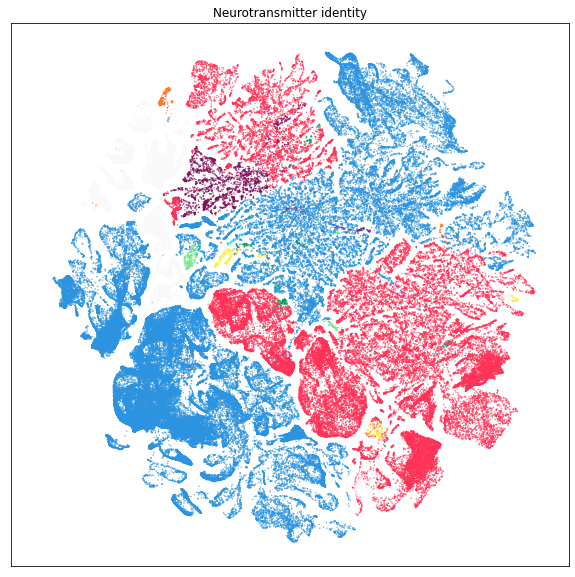

In [11]:
subsampled = joined.loc[::15]
fig, ax = plot_umap(subsampled['x'], subsampled['y'],cc=subsampled['neurotransmitter_color'])
res = ax.set_title("Neurotransmitter identity")

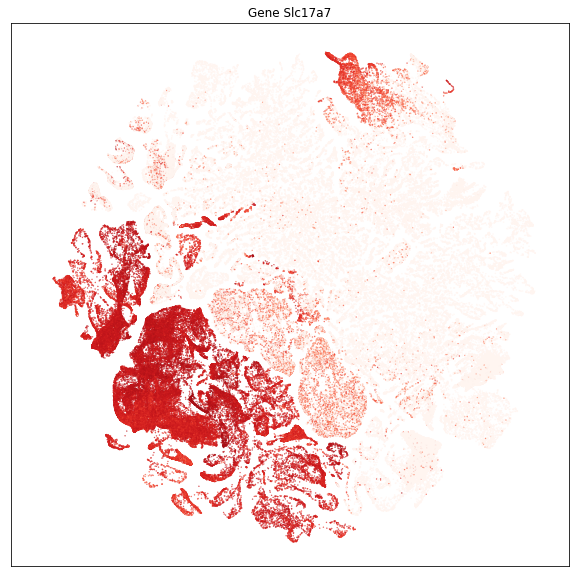

In [12]:
fig, ax = plot_umap(subsampled['x'], subsampled['y'],val=subsampled['Slc17a7'],cmap='Reds')
res = ax.set_title("Gene Slc17a7")

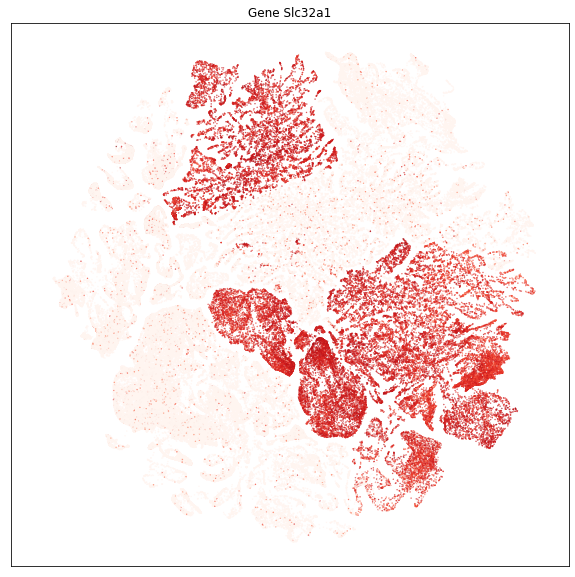

In [13]:
fig, ax = plot_umap(subsampled['x'], subsampled['y'],val=subsampled['Slc32a1'],cmap='Reds')
res = ax.set_title("Gene Slc32a1")

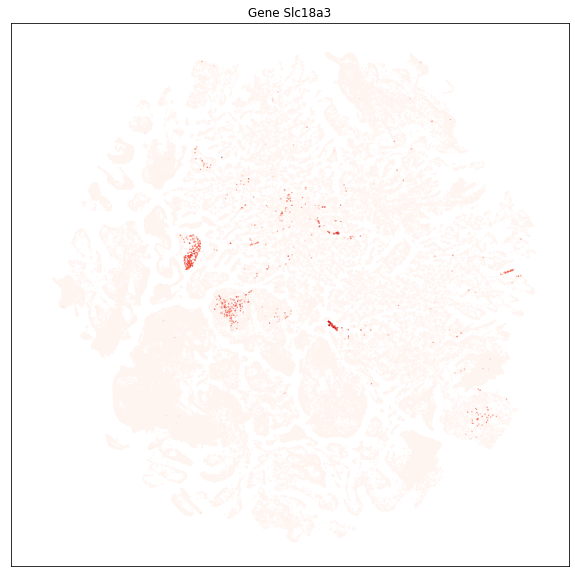

In [14]:
fig, ax = plot_umap(subsampled['x'], subsampled['y'],val=subsampled['Slc18a3'],cmap='Reds')
res = ax.set_title("Gene Slc18a3")

Grouping expression by dissection region of interest shows that each of these genes have distinct spatial patterns. Genes Slc17a7 is enriched in the cortex, Slc32a1 in the striatum, Slc17a6 and Slc18a3 in the thalamus, Slc6a3 and Slc6a4 in the midbrain, Slc6a5 and Slc6a2 in the medulla. 

In [15]:
rpath = metadata['region_of_interest_metadata']['csv']['file']['relative_path']
file = os.path.join( download_base, rpath)
roi = pd.read_csv(file)
roi.set_index('acronym',inplace=True)

In [16]:
agg = aggregate_by_metadata( joined, ntgenes, 'region_of_interest_acronym' )
agg = agg.loc[roi.index] # order roi by anatomical order
agg.style.background_gradient(cmap='Reds')

,Slc17a7,Slc17a6,Slc17a8,Slc32a1,Slc6a5,Slc18a3,Slc6a3,Slc6a4,Slc6a2
acronym,,,,,,,,,
MO-FRP,6.779459,0.764872,0.124955,1.057193,0.004817,0.023999,0.003662,0.004840,0.004914
MOp,7.938808,0.946706,0.168024,1.242897,0.002824,0.031415,0.002057,0.011413,0.004929
SS-GU-VISC,7.277509,1.401445,0.114201,0.869310,0.003143,0.015487,0.004876,0.004939,0.003183
SSp,8.307015,1.844414,0.185158,0.410914,0.001462,0.011789,0.001344,0.001775,0.002975
AUD,8.311963,1.430157,0.127051,0.868285,0.001329,0.012193,0.000529,0.004815,0.003190
AUD-TEa-PERI-ECT,5.746662,0.854585,0.093569,0.932493,0.008958,0.023148,0.008944,0.007187,0.004994
VIS,7.800689,1.483229,0.108854,1.139060,0.002490,0.021208,0.001659,0.014400,0.004219
VIS-PTLp,7.182527,1.488889,0.107182,0.791263,0.002367,0.018489,0.002838,0.004652,0.004844
ACA,6.673850,0.996978,0.148429,1.072592,0.004972,0.020985,0.004386,0.019547,0.006284


### Expression of Tachykinin 2 (Tac2) in the whole brain

In mice, the tachykinin 2 (Tac2) gene encodes neuropeptide called neurokinin B (NkB). Tac2 is produced by neurons in specific regions of the brain know to be invovled in emotion and social behavior. Based on [ISH data](https://mouse.brain-map.org/experiment/siv?id=77279001&imageId=77284584&initImage=ish&coordSystem=pixel&x=5384.5&y=3832.5&z=3) from the Allen Mouse Brain Atlas, Tac 2 is sparsely expressed in the mouse isocortex and densely enriched is specific subcortical regions such the medial habenula (MH), the amygdala and hypothalamus.

<br>
<div>
<img src="Tac2_ISH_Coronal_Section.JPG" width="600"/>
</div>


In this example, we create a dataframe comprising expression values of Tac2 for all cells across the whole brain. As with the thalamus only example, grouping expression by neurotransmitter show that Tac2 gene is highly enriched in cholinergic cell types. With the rest of brain included, we can observe that Tac2 is also enriched in Glut-GABA cell types as well.

In [17]:
exgenes = ['Tac2']
filtered = exp[exgenes]
joined = cell.join( filtered )
subsampled = joined.loc[::15]

In [18]:
agg = aggregate_by_metadata( joined, exgenes, 'neurotransmitter', True )
agg.style.background_gradient(cmap='Reds')

,Tac2
neurotransmitter,
Chol,5.148534
Glut-GABA,1.944914
GABA,0.601072
Glut,0.099000
GABA-Glyc,0.093852
Dopa,0.035979
Hist,0.034632
Sero,0.008437
Nora,0.000000


Anatomically, Tac2 is most enriched in insular, temporal association, perihinal and ectorhinal areas compared to the rest of the cortex and in the hypothalamus.

In [19]:
agg = aggregate_by_metadata( joined, exgenes, 'region_of_interest_acronym', True ).head(8)
agg.style.background_gradient(cmap='Reds')

,Tac2
region_of_interest_acronym,
AI,0.418070
TEa-PERI-ECT,0.387450
HY,0.331020
MOp,0.315590
VIS,0.303723
PL-ILA-ORB,0.303604
PAL,0.303496
MO-FRP,0.302619


Grouping by class, shows that Tac2 is enriched in class "08 MH-LH Glut" with cells restricted to the medial (MH) and lateral (LH) habenula and a mixture of glutamatergic and cholinergic type and "04 CGE GABA" GABAergic cells originating from the caudal ganglionic eminence (CGE).

In [20]:
agg = aggregate_by_metadata( joined, exgenes, 'class', True ).head(8)
agg.style.background_gradient(cmap='Reds')

,Tac2
class,
08 MH-LH Glut,5.037336
04 CGE GABA,2.621625
14 CNU-HYa GABA,0.551792
11 HY GABA,0.453483
10 HY MM Glut,0.399869
15 HY Glut,0.388255
19 MY Glut,0.259901
06 CNU GABA,0.233099


At the next level, grouping by subclass reveals enrichment is highly anatomically localized cell types such as the medial habenula (MH), bed nuclei of the stria terminalis (BST), spinal nucleus of the trigeminal (SPVC), main olfactory blub (MOB), central amygdalar nucleus (CEA) and arcuate hypothalamic nucleus (ARH).

In [21]:
agg = aggregate_by_metadata( joined, exgenes, 'subclass', True ).head(15)
subclass_list = agg.index[0:10]
agg.style.background_gradient(cmap='Reds')

,Tac2
subclass,
063 MH Tac2 Glut,6.698351
105 BST Tac2 Gaba,6.227521
258 SPVC Nmu Glut,5.207479
276 MOB-mi Frmd7 Gaba,4.961338
037 Sncg Gaba,4.184213
036 Vip Gaba,4.138091
095 CEA-BST Crh Gaba,3.569873
121 ARH-PVp Tbx3 Glut,3.021044
053 MSN D1 Sema5a Gaba,1.932273


Plotting Tac2 expression on the UMAP enables you see whole brain expression in one view showing Tac2 expression is highly restricted to a small number of clusters. Further we can compare the expression profile with the top 10 enriched subclasses.

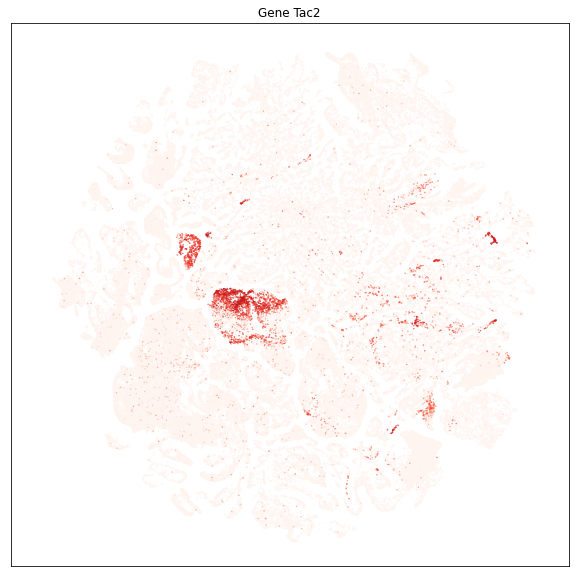

In [22]:
fig, ax = plot_umap(subsampled['x'], subsampled['y'],val=subsampled['Tac2'],cmap='Reds')
res = ax.set_title("Gene Tac2")

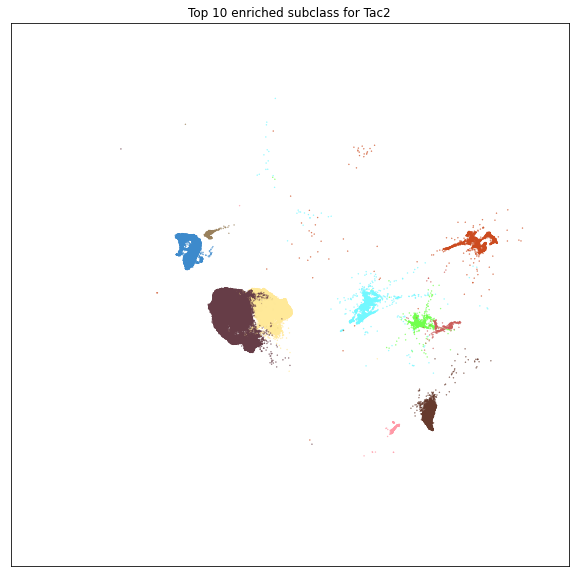

In [23]:
pred = [x in subclass_list for x in joined['subclass']]
filtered = joined[pred]

fig, ax = plot_umap(filtered['x'], filtered['y'],cc=filtered['subclass_color'])
res = ax.set_title("Top 10 enriched subclass for Tac2")